## Example 09 - Multiple vessels - edge constraints

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# OpenTNSIM
import opentnsim.core as core
import opentnsim.graph_module as graph_module
import opentnsim.plot as plot

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

# Graph location
location_graph = "Shape-Files/Rotterdam-Antwerpen-corridor"
name_graph = "edges_2.shp"

### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda)):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

In [2]:
graph = graph_module.Graph()
graph.from_shape(location_graph, name_graph)

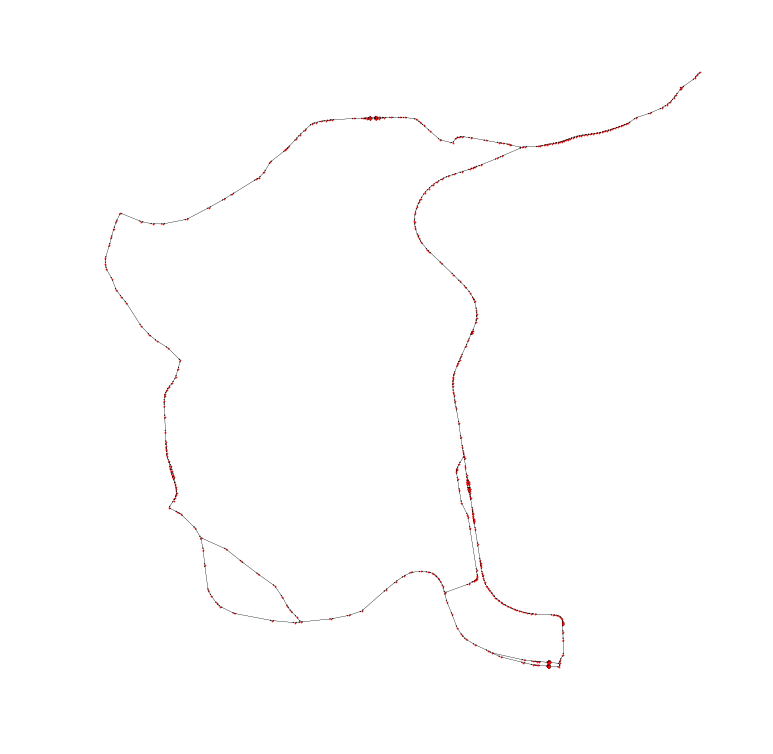

In [3]:
graph.create_graph_new_projection()
graph.plot()

### Make vessels and paths

In [4]:
random.seed(10)

paths = []
random_1 = random.choice(list(graph.graph))
random_2 = random.choice(list(graph.graph))

path = nx.dijkstra_path(graph.graph, random_1, random_2)
paths.append(path)
paths.append(path)

path = nx.dijkstra_path(graph.graph, random_2, random_1)
paths.append(path)
paths.append(path)

In [5]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.ContainerDependentMovable, 
                          core.HasResource, core.Routeable), {})

# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel",
               "route": None,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

vessels = []
for i in range(4):
    vessel = TransportResource(**data_vessel)
    vessel.name = "Vessel " + str(i + 1)
    vessels.append(vessel)

### Start simulation

In [6]:
# Start simpy environment
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))

# Add graph to environment
graph.add_resources(list(graph.graph.edges), np.ones(len(list(graph.graph.edges))), env)
env.FG = graph.graph

In [7]:
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
        if vessel.geometry == nx.get_node_attributes(graph.graph, "geometry")[vessel.route[-1]]:
            break

In [8]:
for i, vessel in enumerate(vessels):
    # Add environment and path to the vessel
    vessel.env = env
    vessel.route = paths[i]
    vessel.geometry = nx.get_node_attributes(graph.graph, "geometry")[paths[i][1]]

    # Add the movements of the vessel to the simulation
    env.process(start(env, vessel))

env.epoch = time.mktime(simulation_start.timetuple())

env.run()

Origin POINT (4.2190502 51.5707988)
Destination POINT (4.21016 51.5774798)
Origin POINT (4.2190502 51.5707988)
Destination POINT (4.21016 51.5774798)
Origin POINT (4.17633 51.3927735)
Destination POINT (4.1687576 51.3878975)
Origin POINT (4.17633 51.3927735)
Destination POINT (4.1687576 51.3878975)


### Obtain vessel log information
The cel below uses the vessel log. The core function *log_entry* is used, which takes four arguments:

- **Log.** A text to describe what is logged.
- **t.** The timestamp.
- **Value.**  The value for the log (for sailing this is the distance).
- **Geometry** The location of the vessel while loggin.

In [9]:
vessel_log = pd.DataFrame.from_dict(vessels[0].log)
vessel_log.head()

,Message,Timestamp,Value,Geometry
0,Start sailing,2019-07-18 10:42:15.000000,,POINT (4.2190502 51.5707988)
1,Sailing to start,2019-07-18 10:58:20.609423,965.609,POINT (4.21016 51.5774798)
2,"Sailing from node (4.210160, 51.577480) to nod...",2019-07-18 10:58:20.609423,0,POINT (4.21016 51.5774798)
3,"Sailing from node (4.210160, 51.577480) to nod...",2019-07-18 11:14:26.218846,0,POINT (4.2190502 51.5707988)
4,"Sailing from node (4.219050, 51.570799) to nod...",2019-07-18 11:14:26.218846,0,POINT (4.2190502 51.5707988)


In [10]:
vessel_log = pd.DataFrame.from_dict(vessels[1].log)
vessel_log.head()

,Message,Timestamp,Value,Geometry
0,Start sailing,2019-07-18 10:42:15.000000,,POINT (4.2190502 51.5707988)
1,Sailing to start,2019-07-18 10:58:20.609423,965.609,POINT (4.21016 51.5774798)
2,"Waiting to pass edge (4.210160, 51.577480) - (...",2019-07-18 10:58:20.609423,0,POINT (4.21016 51.5774798)
3,"Waiting to pass edge (4.210160, 51.577480) - (...",2019-07-18 11:14:26.218846,0,POINT (4.21016 51.5774798)
4,"Sailing from node (4.210160, 51.577480) to nod...",2019-07-18 11:14:26.218846,0,POINT (4.21016 51.5774798)
